In [17]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sys
#from keras.models import Sequential
#from keras.layers import Dense
import pandas as pd
#from keras.callbacks import EarlyStopping, ModelCheckpoint 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import seaborn as sns
import pickle
import os

In [18]:
train = False 

In [19]:
df = pd.read_csv('DataSet_PCP_Change.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   testindex          3130 non-null   int64  
 1   outcome            3130 non-null   int64  
 2   distance           3130 non-null   float64
 3   visit_count        3130 non-null   int64  
 4   claims_daysaway    556 non-null    float64
 5   tier               3121 non-null   float64
 6   fqhc               3130 non-null   int64  
 7   pcp_lookback       3130 non-null   int64  
 8   family_assignment  3130 non-null   int64  
 9   kid                3130 non-null   int64  
 10  is_ped             3130 non-null   int64  
 11  same_gender        3130 non-null   int64  
 12  same_language      3130 non-null   int64  
 13  same_address       3130 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 342.5 KB
None


In [20]:
df['claims_daysaway'] = df['claims_daysaway'].replace(np.nan, 0)
df.head()
print('Total Rows in the dataframe: ',len(df))
#df = df.dropna()

Total Rows in the dataframe:  3130


In [21]:
mode_tier = df ['tier'].mode()
df ['tier'] [df ['tier'].isnull()] = mode_tier

c:\users\user\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
def check_box_plot(column_name,df):
    sns.boxplot(x=df[column_name])

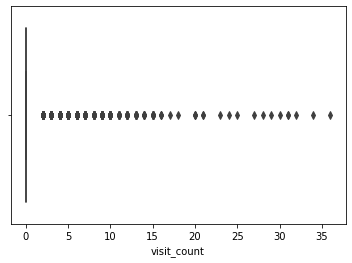

In [23]:
check_box_plot('visit_count',df)


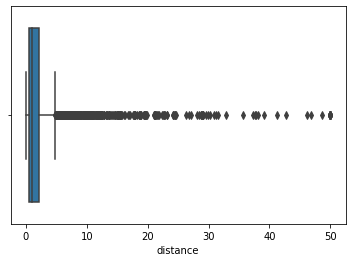

In [24]:
check_box_plot('distance',df)

In [25]:
df = df[(df['distance']<=5)]
print('Total Rows in dataframe removing rows with outliers: ',len(df))

Total Rows in dataframe removing rows with outliers:  2694


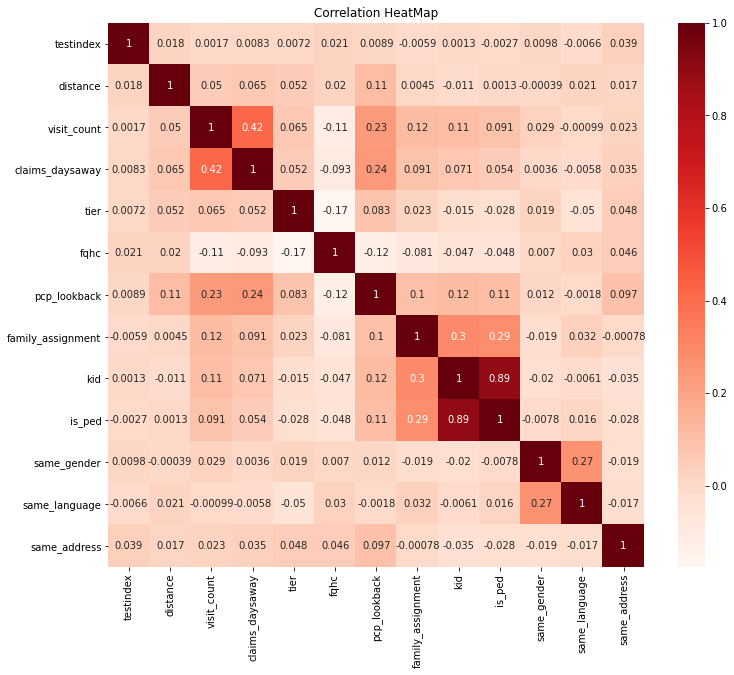

In [26]:
plt.figure(figsize=(12,10))
df_temp = df.copy()
del df_temp['outcome']
cor = df_temp.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation HeatMap')
plt.show()


In [27]:
del df['kid']

In [28]:
y = pd.get_dummies(df.tier, prefix='tier')


In [29]:
final_df = pd.concat([df, y], axis=1)

In [30]:
del final_df['tier']

In [31]:
del final_df['testindex']

In [32]:
final_df.to_csv('pre_processed_data.csv', index = False)

In [33]:
normalized_df=(final_df-final_df.min())/(final_df.max()-final_df.min())


In [34]:
normalized_df.to_csv('pre_processed_data.csv', index = False)

In [35]:
y = normalized_df['outcome'].values

In [36]:
del normalized_df['outcome']

In [37]:
X = normalized_df.values

In [38]:
counter = Counter(y)
print('Class Distribution: ',counter)

Class Distribution:  Counter({0.0: 2608, 1.0: 86})


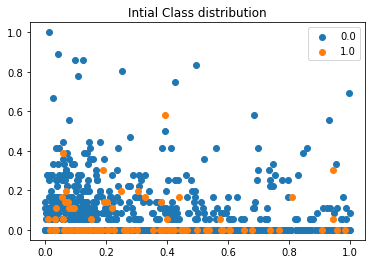

In [39]:
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.title("Intial Class distribution")
plt.show()

Final Class Distribution after Sampling:  Counter({0.0: 860, 1.0: 774})


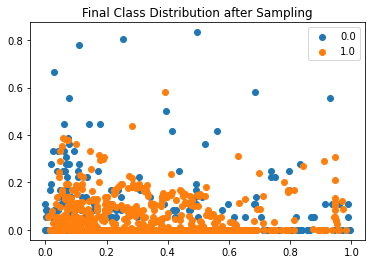

In [40]:
over = SMOTE(sampling_strategy=0.9)
under = RandomUnderSampler(sampling_strategy=0.1, random_state = 100)
steps = [('u', under),('o', over)] #
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
counter = Counter(y)
print('Final Class Distribution after Sampling: ',counter)
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.title("Final Class Distribution after Sampling")
plt.show()

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [42]:
model_path = "model_rf_200_entropy_200.sav"

In [43]:
if train:
    clf=RandomForestClassifier(n_estimators=200, criterion = 'entropy', max_depth = 200)
    clf.fit(X_train,y_train)
    pickle.dump(clf, open(model_path, 'wb'))
else:
    if os.path.exists(model_path):
        clf = pickle.load(open(model_path,'rb'))
    else:
        clf=RandomForestClassifier(n_estimators=200, criterion = 'entropy', max_depth = 200)
        clf.fit(X_train,y_train)
        pickle.dump(clf, open(model_path, 'wb'))
    

In [44]:
importance = clf.feature_importances_

In [45]:
#for i,v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v))
dict_importance = {}
for score,feature_name in zip(importance, normalized_df.columns.values):
    print('Feature Name: %s, Score: %.5f' % (feature_name, score))
    dict_importance[feature_name] = score


Feature Name: distance, Score: 0.28254
Feature Name: visit_count, Score: 0.10400
Feature Name: claims_daysaway, Score: 0.08060
Feature Name: fqhc, Score: 0.05089
Feature Name: pcp_lookback, Score: 0.10256
Feature Name: family_assignment, Score: 0.06231
Feature Name: is_ped, Score: 0.06924
Feature Name: same_gender, Score: 0.07463
Feature Name: same_language, Score: 0.02593
Feature Name: same_address, Score: 0.06217
Feature Name: tier_1.0, Score: 0.02485
Feature Name: tier_2.0, Score: 0.01868
Feature Name: tier_3.0, Score: 0.02353
Feature Name: tier_4.0, Score: 0.01808


In [46]:
temp = 0
for key in dict_importance:
    if 'tier' in key:
        temp = temp + dict_importance[key]
dict_importance['tier'] = temp/4
del dict_importance['tier_1.0']
del dict_importance['tier_2.0']
del dict_importance['tier_3.0']
del dict_importance['tier_4.0']


In [47]:
sorted_dict = dict(sorted(dict_importance.items(), key=lambda kv: kv[1]))

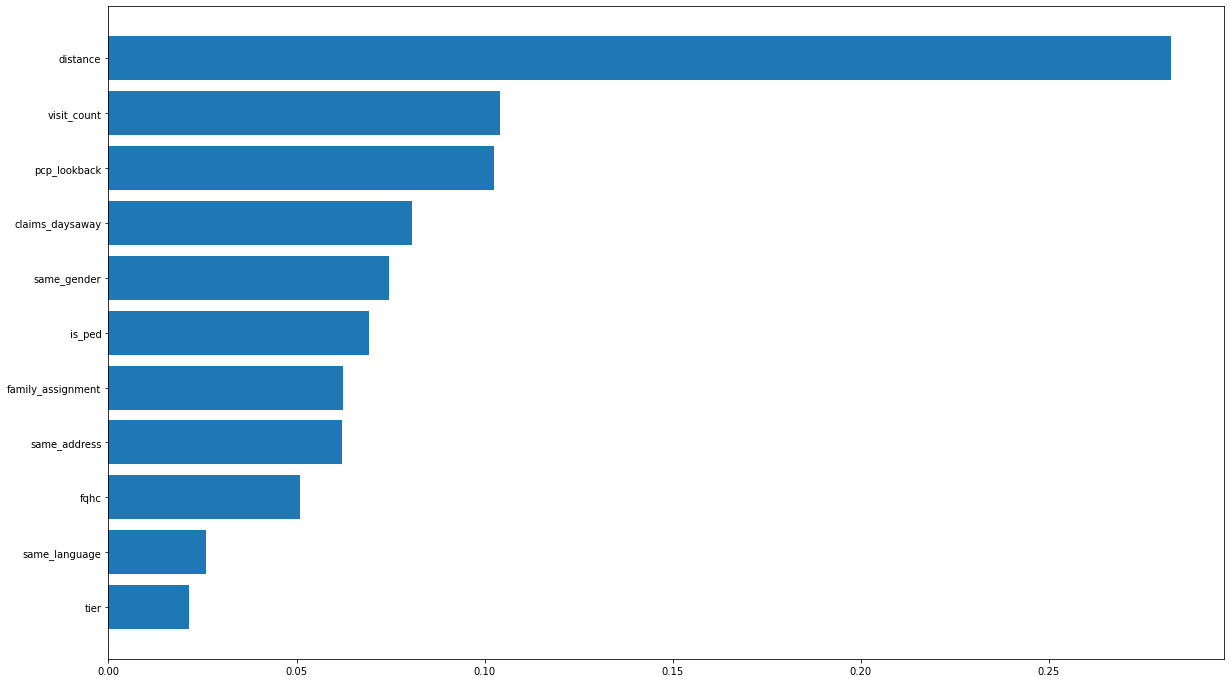

In [48]:
plt.figure(figsize = (20,12))

plt.barh(list(sorted_dict.keys()), list(sorted_dict.values()))
plt.show()

In [49]:
predictions = clf.predict(X_test)

In [50]:
print("Overall Accuracy:",metrics.accuracy_score(y_test, predictions))
print('Confusion Matrix:\n',confusion_matrix(y_test,predictions))
print('Analysis Report:\n',classification_report(y_test,predictions))

Overall Accuracy: 0.9329268292682927
Confusion Matrix:
 [[92  6]
 [ 5 61]]
Analysis Report:
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.94        98
         1.0       0.91      0.92      0.92        66

    accuracy                           0.93       164
   macro avg       0.93      0.93      0.93       164
weighted avg       0.93      0.93      0.93       164

